Load The Data of each Company

In [2]:
import pandas as pd

df_raw_analyst = pd.read_csv('../Data/raw_analyst_ratings.csv') 

## Descriptive Statistics

1. Textual Lengths (Headline Length)

In [17]:
df_raw_analyst['headline_length'] = df_raw_analyst['headline'].apply(len)
print(df_raw_analyst['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


2. Count Articles per Publisher

In [18]:
publisher_counts = df_raw_analyst['publisher'].value_counts()
print(publisher_counts)

publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


3. Analyze Publication Dates

<Axes: xlabel='date_only'>

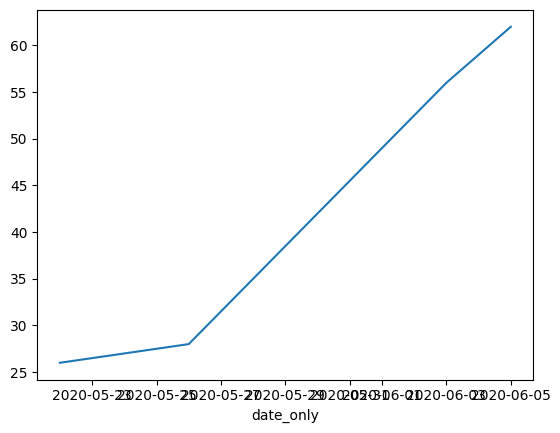

In [20]:
# Convert the 'date' column to datetime, handling mixed formats
df_raw_analyst['date'] = pd.to_datetime(df_raw_analyst['date'], format='mixed', errors='coerce')

# Extract just the date (without time) for analysis
df_raw_analyst['date_only'] = df_raw_analyst['date'].dt.date

# Count the occurrences of each date and sort by date
publication_trends = df_raw_analyst['date_only'].value_counts().sort_index()

# Plot the publication trends over time
publication_trends.plot(kind='line')

## Text Analysis(Sentiment analysis & Topic Modeling):

### 1, Sentimental Analysis

Using VADER (NLTK)

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

batch_size = 1000  # Adjust based on your system's capacity
sentiment_scores = []

for i in range(0, len(df_raw_analyst), batch_size):
    batch = df_raw_analyst['headline'].iloc[i:i+batch_size]
    batch_sentiment = batch.apply(lambda x: sia.polarity_scores(x)['compound'])
    sentiment_scores.extend(batch_sentiment)

df_raw_analyst['sentiment'] = sentiment_scores

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 104]
[nltk_data]     Connection reset by peer>


Analyze Sentiment by Stock

In [6]:
stock_sentiment = df_raw_analyst.groupby('stock')['sentiment'].mean()
print(stock_sentiment)

stock
A       0.070783
AA      0.042446
AAC     0.029539
AADR    0.084750
AAL     0.062757
          ...   
ZTR     0.037974
ZTS     0.078401
ZU      0.077445
ZUMZ    0.036719
ZX      0.008416
Name: sentiment, Length: 6204, dtype: float64


Visualization

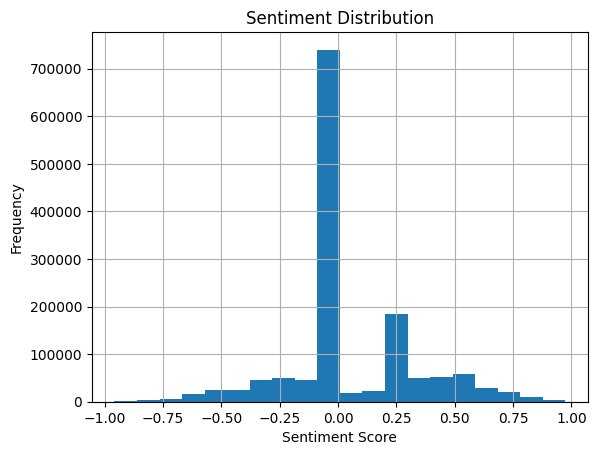

In [7]:
import matplotlib.pyplot as plt

df_raw_analyst['sentiment'].hist(bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### 2, Topic Modeling

a. Preprocessing the Text

In [ ]:
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the stopwords corpus
nltk.download('stopwords')

# Preprocessing function
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in simple_preprocess(text) if token not in stopwords.words('english')]

# Apply preprocessing to the headlines
df_raw_analyst['processed'] = df_raw_analyst['headline'].apply(preprocess)

b. Creating the Dictionary and Corpus:

In [ ]:
# Create a dictionary representation of the documents
dictionary = Dictionary(df_raw_analyst['processed'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in df_raw_analyst['processed']]

c. Applying LDA:

In [ ]:
# Train the LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Display the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

### Combining Sentiment Analysis with Topics

In [ ]:
df_raw_analyst['dominant_topic'] = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

# Group by topics and sentiment
topic_sentiment = df_raw_analyst.groupby(['dominant_topic', 'sentiment_label']).size().unstack().fillna(0)

print(topic_sentiment)